## 数据预处理，建立Dataset

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 读取训练集和label
train_csv = pd.read_csv('../dog_breed_identification/labels.csv')
print(len(train_csv))
train_csv

10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [3]:
# 读取训练集和label
print('训练集总数为',len(train_csv))

# 这个class_to_num即作为类别号到类别名称的映射
labels_info = train_csv.iloc[:,1]  # 第2列的标签信息
class_to_num = labels_info.unique()
class_to_num = np.sort(class_to_num)
class_to_num

训练集总数为 10222


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

### 设定图像增广的方法

In [4]:
transform_train = transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    transforms.ToTensor(),
    # 标准化图像的每个通道
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

transform_test = transforms.Compose([
    transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

### 建立Dataset类
我把Dataset设置了以下功能：<br>
1. 可读入csv文件，其含有指定格式的数据(文件名)+标签信息。<br>
根据文件名，用PIL中的Image.open方法读入图片。<br>
在__getitem__中，取到图片数据的方法是用PIL的Image.open方法来实现的。open后传入的文件名就读取自csv文件。
2. 可设定是否为训练集（train=True）<br>
如设定为训练集，我又设定了一个 训练测试比（train_test_ratio），用于在训练集中，人工再分出一小部分测试集用于训练时实时测试准确率（这样的话会给出dataset中测试集的数据索引范围，并且前后使用的**图像增广**的方法也不一样）。<br>
如果不设置train_test_ratio，则不用考虑这个问题。
如果不设为训练集（train=False），即读入测试集，用于测试模型，提交结果。这样返回则是img, fname(id)。
3. 训练集和测试集使用不同的图像增广方法，方法在上面已定义。<br>
包括训练集中如使用了train_test_ratio分出一小部分的测试集，也使用测试集的图像增广法。

建立Dataset后，会预览数据集体验一下这个Dataset的功能。

In [5]:
class dog_dataset(Dataset):
    def __init__(self, csv_path, file_path, train=True, train_test_ratio=None):
        """
        Args:
            csv_path (string): 格式 csv_path = '../dog_breed_identification/labels.csv'
                如果train=True,csv文件为训练集文件名+标签信息,第一列为文件名,第二列为label
                如果train=False,csv文件为验证集的文件名信息,第一列为文件名
            file_path (string): 图片所在文件夹,格式 file_path = '../dog_breed_identification/train/'
            train=True (boolean): 是否读为训练集
            train_test_ratio=None (0~1小数): 仅当train=True时,可设置训练集占比,将训练集分成训练/测试两个部分
        """
        self.train = train

        if self.train==True:  # 仅当train=True时可设train_test_ratio
            if train_test_ratio is not None:
                if train_test_ratio > 0 and train_test_ratio < 1:
                    self.train_test_ratio = train_test_ratio
                else:
                    print('train_test_ratio设置不正确,未成功分配训练/测试集')
                    self.train_test_ratio = None
            else:
                self.train_test_ratio = None
        else:
            self.train_test_ratio = None


        self.file_path = file_path
        # 判断是否都为jpg文件
        file_list = os.listdir(self.file_path)
        jpg_tocheck = [i.split('.')[1] for i in file_list if i.split('.')[1] == 'jpg']
        assert len(jpg_tocheck) == len(file_list)

        if self.train==True:
            # 读取训练集的信息文件
            csv_file = pd.read_csv(csv_path)

            if self.train_test_ratio is None:
                # 建立imgs_filename
                self.imgs_filename = csv_file['id'].tolist()  # 第1列的文件名（id）信息

                labels_info = csv_file.iloc[:,1]  # 第2列的标签信息

                origin_labels = labels_info.tolist()  # 第2列的标签信息List

                class_to_num = labels_info.unique()
                class_to_num = np.sort(class_to_num) # 建立类别名到类别号的映射
                print('读取csv文件成功,已建立类别名到类别号的映射,映射规则为类别名按字符串排列,即sorted(类名列.unique().tolist())')

                csv_file['class_num'] = labels_info.apply(lambda x: np.where(class_to_num == x)[0][0])  # 建立新列，完成类别名到类别号的映射
                # 建立labels
                self.labels = csv_file['class_num'].tolist()
            
            else: # 当设定了训练集/测试集比率时，训练集会随机分出一部分数据归为测试集。
                self.num_train = int(len(csv_file) * train_test_ratio)
                num_test = len(csv_file) - self.num_train
                csv_file = csv_file.sample(frac=1).reset_index(drop=True) # 数据集重新打乱
                print('设定了训练集占比,随机分出训练集',str(self.num_train),'个；分出测试集',str(num_test),'个。')

                # 建立imgs_filename
                self.imgs_filename = csv_file['id'].tolist()  # 第1列的文件名（id）信息

                labels_info = csv_file.iloc[:,1]  # 第2列的标签信息

                origin_labels = labels_info.tolist()  # 第2列的标签信息List

                class_to_num = labels_info.unique()
                class_to_num = np.sort(class_to_num) # 建立类别名到类别号的映射
                print('读取csv文件成功,已建立类别名到类别号的映射,映射规则为类别名按字符串排列,即sorted(类名列.unique().tolist())')

                csv_file['class_num'] = labels_info.apply(lambda x: np.where(class_to_num == x)[0][0])  # 建立新列，完成类别名到类别号的映射
                # 建立labels
                self.labels = csv_file['class_num'].tolist()
                print('前', str(self.num_train), '个数据为训练集，已使用训练集的数据增强；之后的视作测试集，已使用测试集的数据增强。')

        else:  # 验证集的情况
            # 读取验证集的信息文件
            csv_file = pd.read_csv(csv_path)
            # 建立imgs_filename
            self.imgs_filename = csv_file['id'].tolist()  # 第1列的文件名（id）信息
        
        print()

    def __getitem__(self, index):
        fname = self.imgs_filename[index] + '.jpg'
        img = Image.open(self.file_path + fname)

        if self.train_test_ratio is None:
            if self.train==True:
                label = self.labels[index]
                return transform_train(img), label  # 使用训练集的数据增强
            else:  # 验证集上增加返回一个文件名（id）的信息，方便后期识别。并使用测试集的数据增强
                return transform_test(img), fname

        else:  # 设定了train_test_ratio的情形
            label = self.labels[index]
            if index < self.num_train: # 前num_train数为训练集,使用训练集的数据增强
                return transform_train(img), label
            else:  # num_train之后为测试集,使用测试集的数据增强
                return transform_test(img), label

    def __len__(self):
        return len(self.imgs_filename)

# 在__getitem__中，按index取到图片的方法就是用PIL中的Image.open来实现的。

### 预览训练集和验证集

读取csv文件成功,已建立类别名到类别号的映射,映射规则为类别名按字符串排列,即sorted(类名列.unique().tolist())

第一张图的类别号、数据集的长度： 19 10222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


一个batch的数据形状、第一张图的类别： torch.Size([128, 3, 224, 224]) tensor(19)
第一张图：


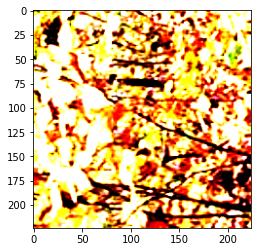

In [6]:
# 读取训练集看看
csv_path = '../dog_breed_identification/labels.csv'
file_path = '../dog_breed_identification/train/'
Dog_dataset = dog_dataset(csv_path, file_path, train=True)
print('第一张图的类别号、数据集的长度：', Dog_dataset[0][1], len(Dog_dataset))

train_iter = DataLoader(Dog_dataset, batch_size=128, shuffle=False)
X, y = next(iter(train_iter))

print('一个batch的数据形状、第一张图的类别：',X.shape, y[0])
print('第一张图：')
plt.imshow(torch.transpose(X[0], 0, 2))

设定了训练集占比,随机分出训练集 9199 个；分出测试集 1023 个。
读取csv文件成功,已建立类别名到类别号的映射,映射规则为类别名按字符串排列,即sorted(类名列.unique().tolist())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


前 9199 个数据为训练集，已使用训练集的数据增强；之后的视作测试集，已使用测试集的数据增强。

第一张图片的类别号、数据集长度： 95 10222
第9200张图片(为测试集) ：


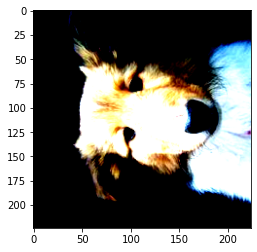

In [7]:
# 把训练集分为训练+测试集看看
csv_path = '../dog_breed_identification/labels.csv'
file_path = '../dog_breed_identification/train/'
Dog_dataset = dog_dataset(csv_path, file_path, train=True, train_test_ratio=0.9)
print('第一张图片的类别号、数据集长度：', Dog_dataset[0][1], len(Dog_dataset))
print('第9200张图片(为测试集) ：')
plt.imshow(torch.transpose(Dog_dataset[9199][0], 0, 2))


第1张图片的形状、第1张图片的类别号、数据集的长度： torch.Size([3, 224, 224]) 000621fb3cbb32d8935728e48679680e.jpg 10357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


第一批次最后一张图片:


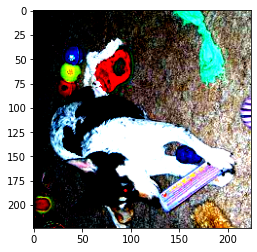

In [8]:
# 读取验证集看看
csv_path = '../dog_breed_identification/sample_submission.csv'
file_path = '../dog_breed_identification/test/'
Dog_dataset = dog_dataset(csv_path, file_path, train=False)
print('第1张图片的形状、第1张图片的类别号、数据集的长度：', (Dog_dataset[0][0]).shape, Dog_dataset[0][1], len(Dog_dataset))

valid_iter = DataLoader(Dog_dataset, batch_size=128)
X, y = next(iter(valid_iter))
print('第一批次最后一张图片:')
plt.imshow(torch.transpose(X[-1], 0, 2))

## 定义和初始化模型
直接使用预训练好的模型固定参数，最后加一个1000类到120的非线性激活函数+全连接层

In [9]:
def get_net(devices):
    finetune_net = torch.nn.Sequential()
    # finetune_net.features = torchvision.models.resnet34(pretrained=True)
    finetune_net.features = torchvision.models.resnet50(pretrained=True)
    # 定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = torch.nn.Sequential(torch.nn.Linear(1000, 256),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(256, 120))
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices)
    # 冻结参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

pretrained_net = get_net(device)

In [11]:
# 优化器选取
lr, wd = 0.001, 0.001
optimizer = torch.optim.AdamW(pretrained_net.parameters(), lr=lr, weight_decay=wd)

## 设置训练集和测试集
我们需要把训练集自己分成训练/测试集，在之前建的Dataset对象中传入 训练集占比 即可。<br>
我设成了0.96

In [12]:
# 先建立训练数据集
csv_path = '../dog_breed_identification/labels.csv'
file_path = '../dog_breed_identification/train/'
Dog_dataset_train = dog_dataset(csv_path, file_path, train=True, train_test_ratio=0.96)

设定了训练集占比,随机分出训练集 9813 个；分出测试集 409 个。
读取csv文件成功,已建立类别名到类别号的映射,映射规则为类别名按字符串排列,即sorted(类名列.unique().tolist())
前 9813 个数据为训练集，已使用训练集的数据增强；之后的视作测试集，已使用测试集的数据增强。



In [13]:
# 上面在训练集中分出一部分测试集，以便训练时第一时间查看训练的效果

indices1 = range(9813)
train_set = torch.utils.data.Subset(Dog_dataset_train, indices1)

indices2 = range(9813, len(Dog_dataset_train))
test_set = torch.utils.data.Subset(Dog_dataset_train, indices2)
print('在数据集中分出训练集和测试(验证)集各：', len(train_set), len(test_set))

在数据集中分出训练集和测试(验证)集各： 9813 409


## 训练

In [14]:
# 定义train函数，使用GPU训练并评价模型
import time

# 测试集上评估准确率
def evaluate_accuracy(data_iter, net, device=None):
    """评估模型预测正确率"""
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就用net的device
        device = list(net.parameters())[0].device

    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            # # 测试集上做数据增强（normalize）
            # X = test_augs(X)
            if isinstance(net, torch.nn.Module):
                net.eval()  # 将模型net调成 评估模式，这会关闭dropout

                # 累加这一个batch数据中判断正确的个数
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()

                net.train()   # 将模型net调回 训练模式
            else:   # 针对自定义的模型（几乎用不到）
                if('is_training' in net.__code__.co_varnames):  # 如果有is_training这个参数
                    # 将 is_training 设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print('training on ', device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
                % (epoch+1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [15]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=10):
    train_iter = DataLoader(train_set, batch_size)
    test_iter = DataLoader(test_set, batch_size)
    loss = torch.nn.CrossEntropyLoss()
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [16]:
train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 2.1597, train acc 0.477, test acc 0.775, time 74.6 sec
epoch 2, loss 0.6236, train acc 0.656, test acc 0.809, time 72.6 sec
epoch 3, loss 0.3645, train acc 0.691, test acc 0.812, time 73.1 sec
epoch 4, loss 0.2634, train acc 0.707, test acc 0.822, time 74.9 sec
epoch 5, loss 0.2100, train acc 0.706, test acc 0.831, time 70.6 sec
epoch 6, loss 0.1647, train acc 0.724, test acc 0.831, time 72.8 sec
epoch 7, loss 0.1384, train acc 0.728, test acc 0.831, time 72.4 sec
epoch 8, loss 0.1214, train acc 0.726, test acc 0.824, time 72.9 sec
epoch 9, loss 0.1058, train acc 0.736, test acc 0.839, time 72.9 sec
epoch 10, loss 0.0941, train acc 0.737, test acc 0.829, time 73.1 sec


## 模型存储

In [17]:
# pretrained_net 是 torchvision.models.resnet50() 类
path = 'net_pretrained.pt'
torch.save(pretrained_net.state_dict(), path)

## 验证数据，上传

In [18]:
test_csv = pd.read_csv('../dog_breed_identification/sample_submission.csv')
print(len(test_csv))
test_csv.head()

10357


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,8.131564e-08,3.739072e-05,1.622522e-10,1.412562e-11,4.329946e-10,4.364912e-07,1.096390e-10,1.403163e-09,7.422208e-11,...,7.537296e-07,1.023146e-10,1.063353e-12,1.384691e-09,5.136680e-13,3.448304e-08,9.915386e-09,8.182301e-07,1.454858e-11,1.016765e-07
1,00102ee9d8eb90812350685311fe5890,1.118222e-08,1.436210e-08,7.229003e-14,6.753473e-11,4.213276e-09,1.330584e-07,4.838193e-10,1.717785e-09,2.252844e-14,...,7.368915e-06,4.767928e-11,1.108373e-12,7.860412e-10,1.233858e-11,1.598396e-10,2.964726e-07,4.013900e-08,5.458939e-14,4.955269e-09
2,0012a730dfa437f5f3613fb75efcd4ce,1.158202e-12,5.968328e-04,2.701356e-12,1.939278e-10,2.035751e-10,7.206506e-08,4.349502e-14,1.391262e-12,8.067165e-09,...,1.713534e-08,3.583457e-12,1.260294e-09,2.282888e-08,8.674917e-09,3.647109e-04,1.030260e-09,1.998524e-06,2.277481e-12,4.481807e-08
3,001510bc8570bbeee98c8d80c8a95ec1,5.048399e-05,1.753395e-06,1.888595e-10,7.883879e-09,5.738963e-07,1.990644e-08,1.385829e-11,9.907979e-08,1.720254e-09,...,3.969265e-08,3.795647e-13,3.641931e-09,3.177675e-10,6.031966e-08,1.607848e-09,6.714420e-10,6.706266e-06,8.762000e-13,2.948624e-06
4,001a5f3114548acdefa3d4da05474c2e,1.679156e-04,9.432920e-05,3.995534e-10,3.181240e-09,1.202668e-09,1.865812e-08,9.951219e-09,1.664668e-09,1.583176e-10,...,1.402052e-05,1.171066e-11,2.161099e-10,7.287738e-11,2.705124e-11,1.164694e-08,3.798686e-07,1.772602e-06,3.821700e-09,1.699274e-05


In [19]:
# 对比test_csv中的类顺序与class_to_num顺序是否一致，应当都是按字符串顺序排序的
temp = test_csv.columns.tolist()
temp.pop(0) # 去掉第一个'id'
print(temp == class_to_num.tolist())

True


### 读取验证集



第1张图片的形状、第1张图片的类别号、数据集的长度： torch.Size([3, 224, 224]) 000621fb3cbb32d8935728e48679680e.jpg 10357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


000621fb3cbb32d8935728e48679680e.jpg


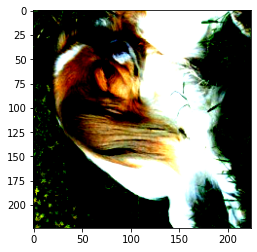

In [20]:
# 读取验证集看看
csv_path = '../dog_breed_identification/sample_submission.csv'
file_path = '../dog_breed_identification/test/'
Dog_dataset = dog_dataset(csv_path, file_path, train=False)
print('第1张图片的形状、第1张图片的类别号、数据集的长度：', (Dog_dataset[0][0]).shape, Dog_dataset[0][1], len(Dog_dataset))

valid_iter = DataLoader(Dog_dataset, batch_size=128)
# 查看一下验证集上的第1张图片
X, y = next(iter(valid_iter))
# 查看验证集第1个数据。valid_iter是按原顺序读取的。
plt.imshow(torch.transpose(X[0],0,2))
print(y[0])

### 定义预测函数，预测

In [21]:
# 定义预测函数
def valid_output(valid_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就用net的device
        device = list(net.parameters())[0].device

    with torch.no_grad():
        y_output = []
        id = []
        for X, y in valid_iter:
            # 验证集上做数据增强（normalize）
            X = X.to(device)
            net.eval() # 将模型net调成评估模式
            y_hat = torch.softmax(net(X), dim=0)
            y_hat = y_hat.cpu().tolist()
            y_output += y_hat
            id += list(y)

        return id, y_output

# 测试模式
pretrained_net.eval()

id, output = valid_output(valid_iter, pretrained_net)
print(len(output))

10357


In [22]:
# 将结果写入sample_submission.csv
with open('../dog_breed_identification/sample_submission.csv', 'w') as f:
    f.write('id,' + ','.join(class_to_num.tolist()) + '\n')
    for id, output in zip(id, output):
        f.write(id.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')